# Retenção de funcionários

## 1. Introdução

O desgaste dos funcionários pode ser muito caro para as empresas: os relatórios mostram que custa aos empregadores 33% do salário anual de um funcionário para contratar um substituto se esse funcionário sair. Além disso, pode comprometer a produtividade, causar perda de conhecimento e diminuir o moral da equipe.

Assim, fornecer soluções que possam prever a rotatividade de funcionários pode ser muito benéfico para as empresas. Além disso, usando a Análise de Sobrevivência e levando em consideração a dimensão do tempo, torna-se possível prever quando um funcionário irá se demitir.

![](https://cdn.pixabay.com/photo/2019/04/26/16/30/id-4157974_960_720.jpg)

## 2 - Contexto

Nesse este tutorial, usaremos o conjunto de dados de recursos humanos Employee Attrition para demonstrar a utilidade da Análise de Sobrevivência.

### 2.1 - Descrição e visão geral

Aqui, consideraremos as seguintes features:

**time_spend_company:** Tempo na empresa

**left:** Especifica se o funcionário deixou a empresa

**satisfaction_level:** Nível de satisfação do funcionário

**last_evaluation:** Pontuação da última avaliação

**number_projects:** Número de projetos atribuídos ao funcionário

**average_montly_hours:** Média mensal de horas trabalhadas

**work_accident:** Se o empregado sofreu um acidente de trabalho

**department:** Nome do departamento/área funcional especializada dentro da empresa

**salary:** Categoria salarial

**promotion_last_5years:** Se o empregado foi promovido nos últimos 5 anos

In [1]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset

# Reading the dataset
raw_dataset = Dataset('employee_attrition').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head()

The raw_dataset has the following shape: (14999, 10).


,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_projects        14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### 2.2 - Transformação das variáveis categóricas

Vamos codificar as variáveis categóricas em vetores one-hot e definir as váriaveis de modelagem:

In [3]:
# Creating the time and event columns
time_column = 'time_spend_company'
event_column = 'left'

# Creating one-hot vectors
categories = ['department', 'salary']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)
dataset.head()

# Creating the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

## 3 - Análise Exploratória de Dados

Faremos uma análise exploratória de dados mais detalhada aqui. Vamos verificar se o conjunto de dados contém valores nulos ou se possui linhas duplicadas, verificar as correlações entre as variáveis, etc.

### 3.1 - Valores nulos e duplicados

A primeira coisa a fazer é verificar se o raw_dataset contém valores Null e tem linhas duplicadas.

In [4]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The dataset contains 0 null values
The dataset contains 3008 duplicates


O conjunto de dados não tem nenhum valor nulo, mas tinha 3.008 linhas duplicadas, que removemos.

### 3.2 - Correlações

Vamos calcular e visualizar a correlação entre as variáveis

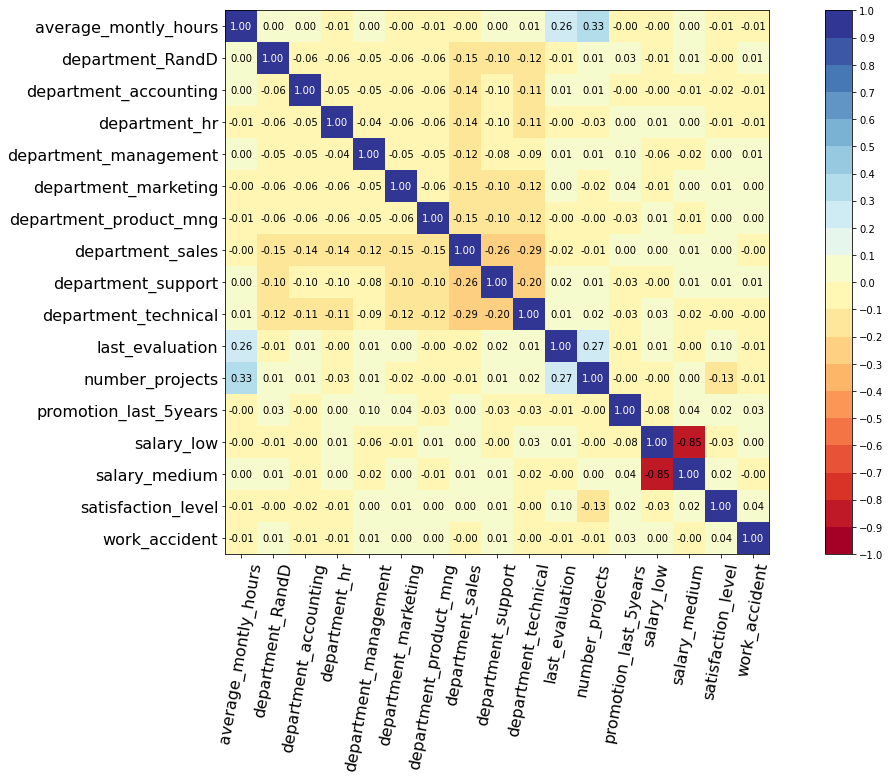

In [5]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(20,10), text_fontsize=10)

Isso mostra que há uma grande correlação entre as variáveis `salaray_low` e `salaray_medium`. Então, removeremos `salaray_low`.

In [6]:
del dataset['salary_low']
features = np.setdiff1d( dataset.columns, [time_column, event_column] ).tolist()


### 3.3 - Visualização dos dados

Vamos conferir/visualizar as estatísticas das variáveis:

#### 3.3.1 - Variáveis numéricas

Vamos exibir o boxplot e o histograma de cada feature.


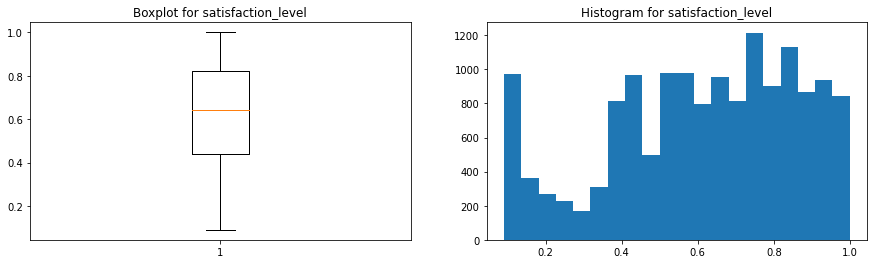

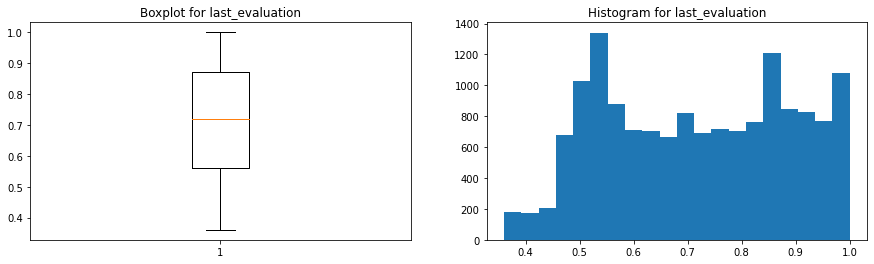

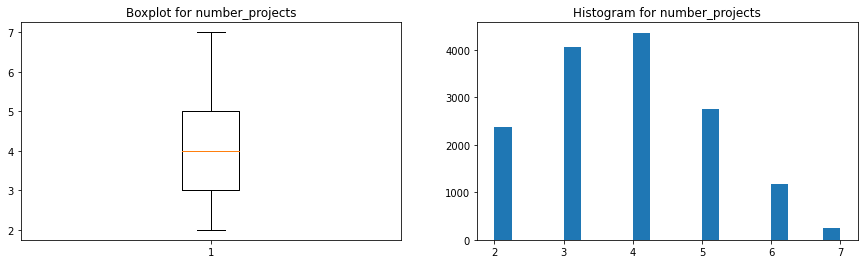

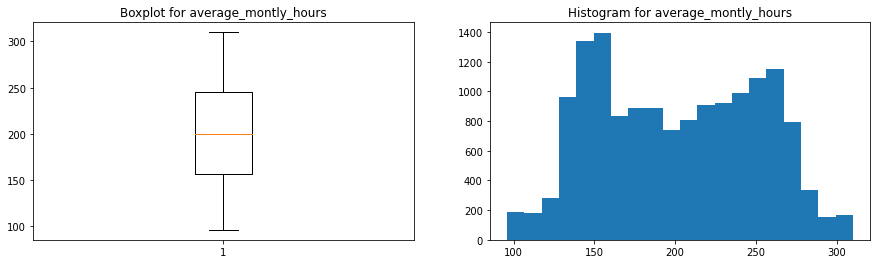

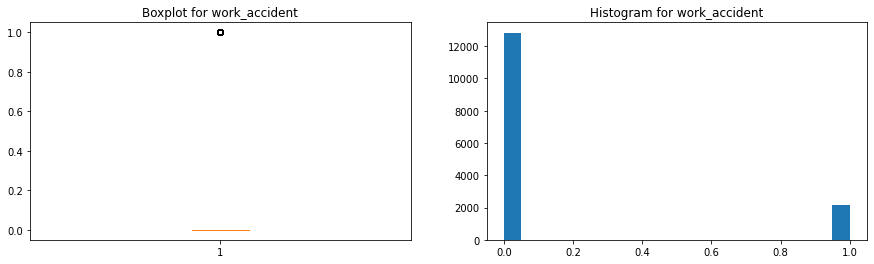

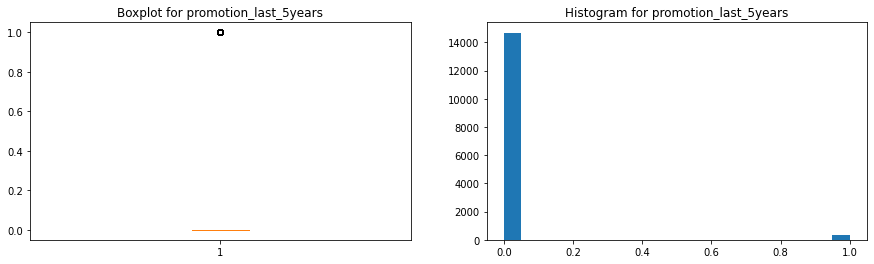

In [7]:
numerical = ['satisfaction_level', 'last_evaluation', 'number_projects',
       'average_montly_hours', 'work_accident', 'promotion_last_5years']

for feature in numerical:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title('Boxplot for {}'.format(feature))

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title('Histogram for {}'.format(feature))

    # Display
    plt.show()

#### 3.3.2 - Variáveis categóricas

Vamos exibir as ocorrências das categorias em um gráfico de barras para cada feature

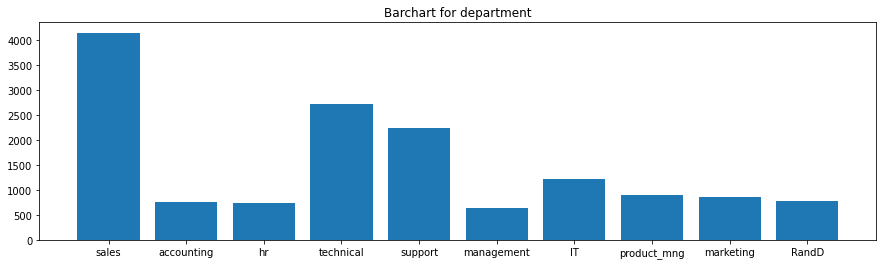

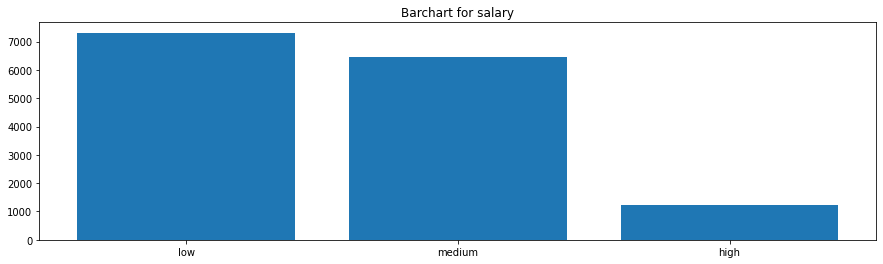

In [8]:

from collections import Counter

for feature in categories:

    # Creating an empty chart
    fig, ax = plt.subplots(figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Counting the number of occurrences for each category
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())

    # Boxplot
    ax.bar(category, counts)

    # Display
    plt.title( 'Barchart for {}'.format(feature) )
    plt.show()

#### 3.3.3 - Tempo & Evento

Mostraremos as ocorrências de evento e censura, bem como a distribuição da variável de saída para ambas as situações.

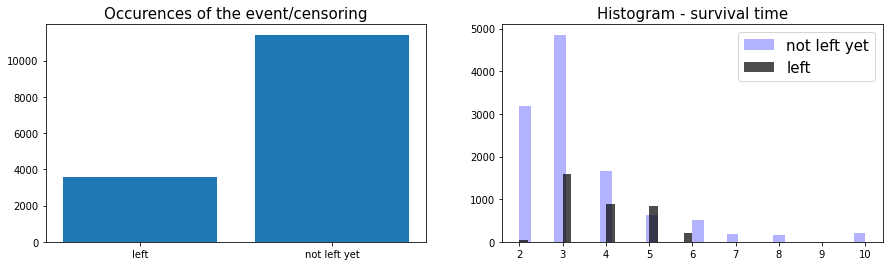

In [9]:
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_dataset['left'].replace({0:'not left yet', 1:'left'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title('Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[ raw_dataset['left'] == 0, 'time_spend_company']
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'not left yet')

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[ raw_dataset['left'] == 1, 'time_spend_company']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'left')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

## 4 - Modelagem

### 4.1 - Construindo o modelo
Para realizar a validação cruzada posteriormente e avaliar o desempenho do modelo, dividiremos o conjunto de dados em conjuntos de treinamento e teste.

In [10]:
# Building training and testing sets #
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split(range(N), test_size=0.2, random_state=42)
data_train = dataset.loc[index_train].reset_index(drop=True)
data_test  = dataset.loc[index_test].reset_index(drop=True)

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

Vamos agora ajustar um modelo de *Conditional Survival Forest* ao conjunto de treinamento.

In [11]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        alpha=0.05, minprop=0.1, max_depth=5, min_node_size=30)

ConditionalSurvivalForestModel

### 4.2 - Importância das variáveis

Construir um modelo de Survival Forest nos permite calcular a importância dos recursos:

In [12]:
# Computing variables importance
csf.variable_importance_table.head(5)

,feature,importance,pct_importance
0,satisfaction_level,10.344060,0.203169
1,average_montly_hours,9.984112,0.196099
2,number_projects,9.873674,0.193930
3,last_evaluation,9.335856,0.183367
4,work_accident,5.647435,0.110922


Graças à importância da característica do modelo CSF, podemos entender as razões por trás da decisão de um funcionário de sair do emprego.

## 5 - Validação Cruzada

Para avaliar o desempenho do modelo, dividimos anteriormente o conjunto de dados original em conjuntos de treinamento e teste, para que agora possamos calcular suas métricas de desempenho no conjunto de teste:

### 5.1 - C-index

O índice C representa a avaliação global do poder de discriminação do modelo: esta é a capacidade do modelo de fornecer corretamente uma classificação confiável dos tempos de sobrevivência com base nas pontuações de risco individuais. Em geral, quando o índice C está próximo de 1, o modelo tem um poder discriminatório quase perfeito; mas se for próximo de 0,5, não tem capacidade de discriminar entre indivíduos de baixo e alto risco.

In [13]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.91


### 5.2 - Brier Score

A pontuação de Brier mede as discrepâncias médias entre o status e as probabilidades estimadas em um determinado momento. Assim, quanto menor a pontuação (geralmente abaixo de 0,25), melhor o desempenho preditivo. Para avaliar a medida de erro geral em vários pontos de tempo, o Integrated Brier Score (IBS) geralmente também é calculado.

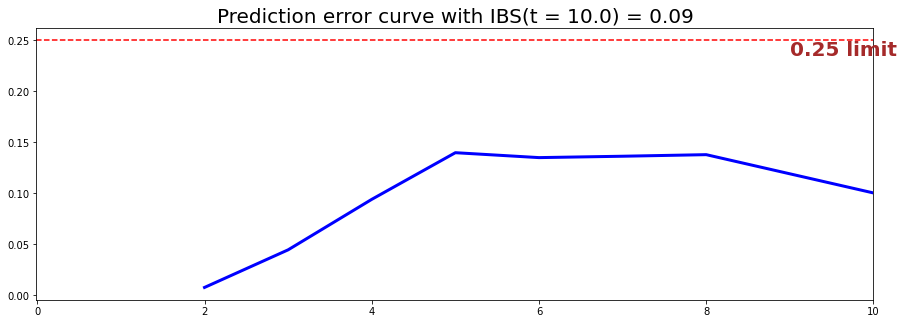

IBS: 0.09


In [14]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=12,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

## 6 - Previsões

### 6.1 - Previsões gerais

Agora que construímos um modelo que parece fornecer ótimos desempenhos, vamos comparar a série temporal do número real e previsto de funcionários que deixaram a empresa, para cada tempo $t$.

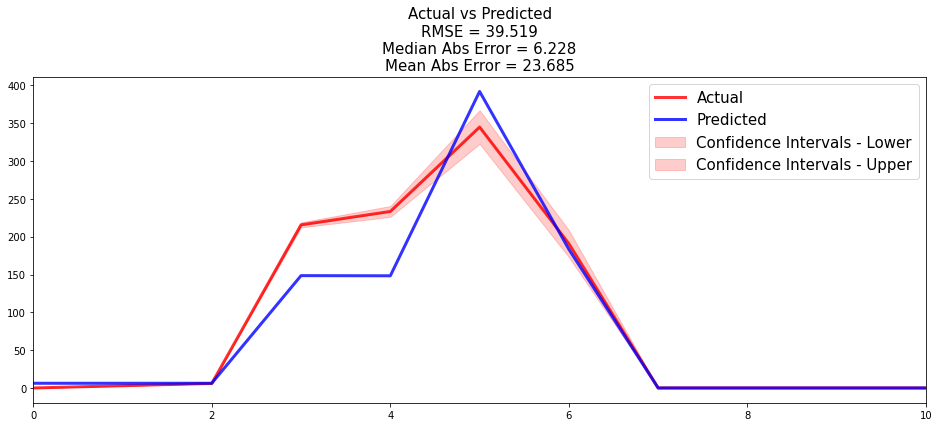

In [15]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

### 6.2 - Previsões individuais

Agora que sabemos que podemos fornecer previsões confiáveis para um grupo inteiro, vamos calcular a probabilidade de um funcionário permanecer empregado para todos os tempos $t$.

Primeiro, podemos construir os grupos de risco com base na distribuição dos escores de risco. A função auxiliar `create_risk_groups`, que pode ser encontrada em `pysurvival.utils.display`, nos ajudará a fazer isso:

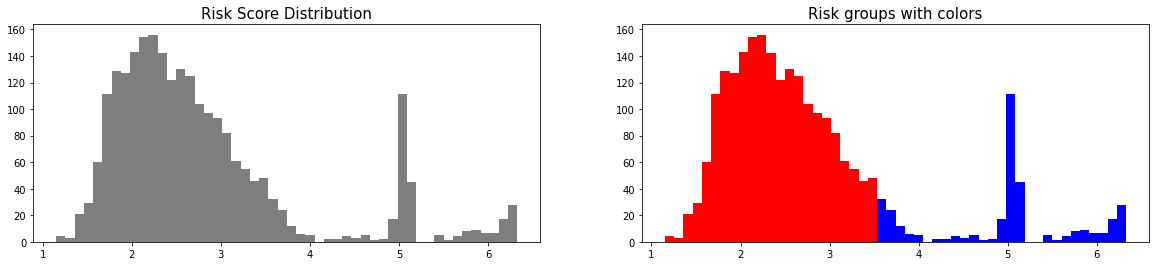

In [16]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=csf, X=X_test,
    use_log = False, num_bins=50, figure_size=(20, 4),
    low= {'lower_bound':0, 'upper_bound':3.5, 'color':'red'},
    high= {'lower_bound':3.5, 'upper_bound':10, 'color':'blue'}
    )

Aqui, é possível distinguir 2 grupos principais, grupos de baixo e alto risco. Como o índice C é alto, o modelo será capaz de classificar perfeitamente os tempos de sobrevivência de uma unidade aleatória de cada grupo, de modo que $t_{high} \leq t_{low}$

Vamos selecionar aleatoriamente unidades individuais em cada grupo e comparar suas funções de velocidade de reembolso. Para demonstrar nosso ponto, selecionaremos propositadamente unidades que vivenciaram um evento para visualizar o tempo real do evento.

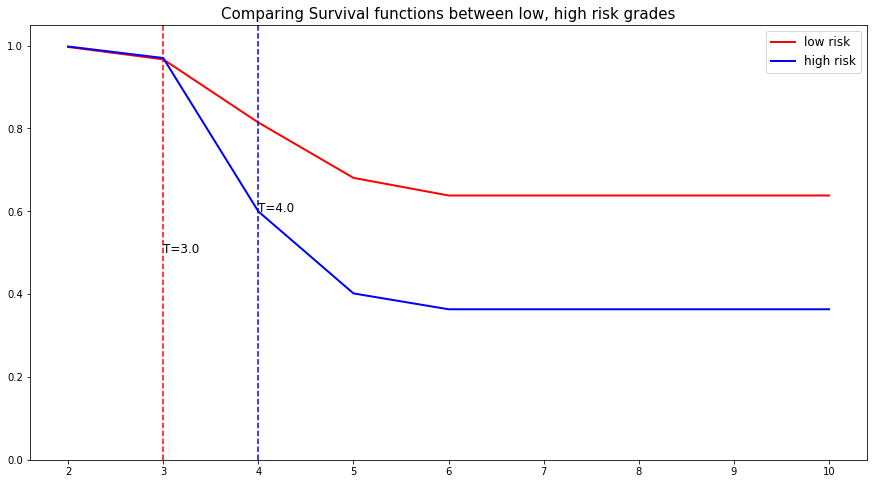

In [17]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 8))

# Selecting a random individual that experienced failure from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = csf.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(csf.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

## 7. Conclusão

Agora podemos salvar nosso modelo para colocá-lo em produção e pontuar futuros funcionários.

In [18]:
# Let's now save our model
# from pysurvival.utils import save_model
# save_model(csf, '/Users/xxx/Desktop/employee_csf.zip')

Em conclusão, podemos ver que é possível prever o número de funcionários que deixarão a empresa em diferentes momentos. 